In [28]:
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np
import joblib
from hyperopt import fmin, tpe, hp, Trials

import warnings

warnings.simplefilter("ignore")


In [29]:
df = pd.read_excel("data/encoding.xlsx")
df.head()

,index,match_id,big_age,program_type,big_race_ethnicity,rationale_for_match,little_participant__race_ethnicity,match_length,avg_cadence_day,max_cadence_day,...,sentiment_change,sentiment_trend,rigidity,fixed_schedule,income_level,stability,big_age_match_start,little_age_match_start,same_gender,race_similarity
0,0,a1v2J0000027CWYQA2,25,Site,Asian;,Both Big and Little didn't list any specific p...,Asian,5.5,35.000000,56,...,0.2265,Stable,1,0,1,1,18,12,True,0.000000
1,1,a1v2J0000027CWfQAM,26,Site,White or Caucasian;,Distance 13.4 miles (23 minutes). L_first_name...,Black or African American,8.5,46.200000,83,...,-0.0037,Stable,1,0,1,2,19,11,True,0.166667
2,2,a1v2J0000027CWiQAM,27,Site,Asian;,Both B_first_name and L_first_name are friendl...,Asian,6.9,35.333333,65,...,0.0330,Stable,1,0,1,1,19,12,True,0.000000
3,3,a1v2J0000027CWoQAM,25,Site,Asian;,"Big, little and parent were in agreement with ...",Asian,7.2,43.750000,106,...,-0.5276,Declined,1,0,1,1,18,8,True,0.000000
4,4,a1v2J0000027CWpQAM,27,Site,White or Caucasian;,"Both shared similar interests, personality and...",Black or African American,7.4,45.750000,85,...,-0.0059,Stable,1,0,1,2,20,11,True,0.166667


In [30]:
df.drop([
    'match_id',
    'sentiment_trend',
    "program_type",
    "big_race_ethnicity",
    "little_participant__race_ethnicity",
    "rationale_for_match",
    "index"
    ], axis=True, inplace=True)

In [31]:
# df = pd.get_dummies(df, columns=["sentiment_trend"])
# df.head()

In [32]:
# 🚀 Split into train and test
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [33]:
# 🚀 Model 1: Time-based features
time_features = ["call_count", "avg_cadence_day", "max_cadence_day", "std"]
X_train_time = train[time_features]
X_test_time = test[time_features]

model_time = lgb.LGBMRegressor()
model_time.fit(X_train_time, train['match_length'])
train['pred_time'] = model_time.predict(X_train_time)
test['pred_time'] = model_time.predict(X_test_time)
# joblib.dump(model_time, "saved/model_time.pkl")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 2611, number of used features: 4
[LightGBM] [Info] Start training from score 23.614477


In [34]:
# 🚀 Model 2: General Features
general_features = [x for x in  df.columns.to_list() if x not in time_features+["match_length"]]
print(general_features)
X_train_gen = train[general_features]
X_test_gen = test[general_features]

model_gen = lgb.LGBMRegressor()
model_gen.fit(X_train_gen, train['match_length'])
train['pred_gen'] = model_gen.predict(X_train_gen)
test['pred_gen'] = model_gen.predict(X_test_gen)
# joblib.dump(model_gen, "saved/model_gen.pkl")

['big_age', 'topic_consistency', 'shared_interest', 'career', 'location', 'family', 'volunteering', 'early_stage_score', 'late_stage_score', 'sentiment_change', 'rigidity', 'fixed_schedule', 'income_level', 'stability', 'big_age_match_start', 'little_age_match_start', 'same_gender', 'race_similarity']
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1070
[LightGBM] [Info] Number of data points in the train set: 2611, number of used features: 18
[LightGBM] [Info] Start training from score 23.614477


In [35]:
# 🚀 Step 3: Train Meta-Model
meta_features = ['pred_time', 'pred_gen']
X_train_meta = train[meta_features]
X_test_meta = test[meta_features]


In [36]:
def objective(params):
    md = int(params['max_depth'])
    ld = int(params['lambda'])
    est = int(params['n_estimators'])
    ss = params['subsample']
    lr = params['learning_rate']
    csbt = params['colsample_bytree']
    model = lgb.LGBMRegressor(
        n_estimators = est,
        max_depth = md,
        subsample = ss,
        reg_lambda = ld,
        colsample_bytree = csbt,
        learning_rate=lr,
        n_jobs = -1,  
    )

    model.fit(X_train_meta, train['match_length'])
    y_pred = model.predict(X_test_meta)
    score = mean_squared_error(test['match_length'],y_pred)

    return score

def optimize(trial):
    params = {
        "max_depth": hp.uniform('max_depth', 2, 80),
        "learning_rate": hp.uniform('learning_rate', 0.01, 0.5),
        "subsample": hp.uniform('subsample',0.5, 1),
        "lambda": hp.uniform('lambda', 1, 10),
        "n_estimators": hp.uniform('n_estimators', 20, 500),
        "colsample_bytree": hp.uniform('colsample_bytree', 0.5, 1),
    }

    rstate = np.random.default_rng(42)
    best = fmin(
        fn=objective,
        space=params,
        algo=tpe.suggest,
        trials=trial,
        max_evals=30,
        rstate=rstate
    )
    return best


In [37]:

trials = Trials()
best = optimize(trials)
# joblib.dump(best, "saved/best_hp.pkl")
print(best)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510                      
[LightGBM] [Info] Number of data points in the train set: 2611, number of used features: 2
[LightGBM] [Info] Start training from score 23.614477 
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510                                               
[LightGBM] [Info] Number of data points in the train set: 2611, number of used features: 2
[LightGBM] [Info] Start training from score 23.614477                          
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain

In [38]:
md = int(best['max_depth'])
ld = int(best['lambda'])
est = int(best['n_estimators'])
ss = best['subsample']
lr = best['learning_rate']
csbt = best['colsample_bytree']

In [39]:

meta_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators = est,
    max_depth = md,
    subsample = ss,
    reg_lambda = ld,
    colsample_bytree = csbt,
    learning_rate=lr,
    seed=42)
meta_model.fit(X_train_meta, train['match_length'])
test['final_pred'] = meta_model.predict(X_test_meta)
# joblib.dump(meta_model, "saved/meta_model.pkl")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2611, number of used features: 2
[LightGBM] [Info] Start training from score 23.614477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [40]:
# 🚀 Evaluate
rmse =np.sqrt( mean_squared_error(test['match_length'], test['final_pred']))
print(f"Final Model RMSE: {rmse:.4f}")

Final Model RMSE: 2.6442


<Axes: xlabel='match_length', ylabel='final_pred'>

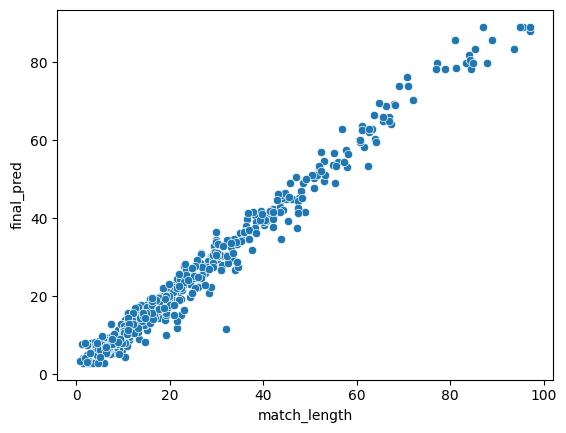

In [41]:
import seaborn as sns

sns.scatterplot(x=test['match_length'], y=test['final_pred'])